Intensity vs Fermi Chopper frequency -- Chopper 1

Just try the original parameters

In [1]:
cd ~/dv/sns-chops/resolution/ARCS/PyChop/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/PyChop


In [2]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

In [3]:
from mcni.utils import conversion as C

In [4]:
%matplotlib notebook

# Exp data

In [5]:
import Vdata2018
reload(Vdata2018)

<module 'Vdata2018' from 'Vdata2018.pyc'>

In [6]:
expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC1_2018_v2.dat'))

reading data. please wait...
  done


In [7]:
monitor_int_data = np.loadtxt('../V_Cali_MonitorInt_FC1_2018_v2.dat')
runno2monitorint = dict()
for runno, mint in monitor_int_data:
    runno2monitorint[int(runno)] = mint

In [8]:
unique_nominal_Eis = set( list(expdata.Ei_list)) 

In [9]:
# unique_nominal_Eis

# Load mcvine sims -- skip for now

In [11]:
# mcvine_table = np.loadtxt('../mcvine-FWHM-counts.dat')

In [14]:
# mcvine_Eis, mcvine_freqs, mcvine_FWHMs, mcvine_counts = mcvine_table.T

# Try plotting one

In [58]:
Ei = 600.

In [59]:
condition = np.isclose(expdata.vdata.Energy, Ei)

In [60]:
expdata.vdata.RunNumber[condition]

5      107525.0
31     107551.0
57     107577.0
84     107604.0
111    107631.0
183    108386.0
194    108397.0
207    108410.0
222    108425.0
239    108442.0
274    107496.0
Name: RunNumber, dtype: float64

In [61]:
expdata.chopper_freqs[condition]

array([ 120.,  240.,  360.,  480.,  600.,  180.,  300.,  420.,  540.,
        600.,   60.])

In [62]:
mint = np.array([runno2monitorint[rn] for rn in expdata.vdata.RunNumber[condition]])

In [63]:
# mcvine_conditions = np.isclose(mcvine_Eis, Ei)

In [64]:
scale_vscatt2mcvine = 1.1e6
scale_monitor2mcvine = 8e-3

<IPython.core.display.Javascript object>


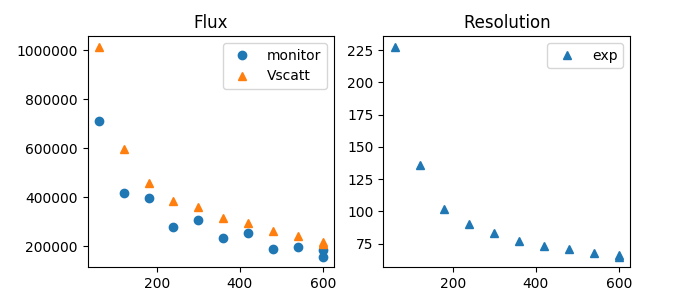

In [65]:
plt.figure(figsize=(7, 3))

freqs = expdata.chopper_freqs[condition]

plt.subplot(1,2,1)
plt.title('Flux')
# plt.plot(mcvine_freqs[mcvine_conditions], mcvine_counts[mcvine_conditions], 'v', label='mcvine')
plt.plot(freqs, mint*C.e2v(Ei)*scale_monitor2mcvine, 'o', label='monitor')
plt.plot(freqs, expdata.intensity[condition]*scale_vscatt2mcvine, '^', label='Vscatt')
plt.plot()
plt.legend()

plt.subplot(1,2,2)
plt.title('Resolution')
plt.plot(freqs, expdata.FWHM[condition], '^', label='exp')
# plt.plot(mcvine_freqs[mcvine_conditions], mcvine_FWHMs[mcvine_conditions], 'v', label='mcvine')
plt.legend()

PyChop

In [19]:
sys.path.insert(0, "/SNS/users/lj7/dv")

In [20]:
from PyChop import PyChop2

In [21]:
instrument = PyChop2('arcs-opt.yaml', 'ARCS-700-1.5-AST', 600)

In [22]:
instrument.getResFlux(Etrans=0, Ei_in=600., frequency=600)

(array([ 33.50465953]), array([ 26.87549195]))

In [56]:
def flux_res_list_pychop(
    fc_freq_list,
    E=0,
    aperture_width=0.1751, S1=281., S2=79., B1=0.087, B2=0.4, Emod=172., 
    Ei = 600.,
    fc_pslit = 1.52, fc_pslat = 0.35, fc_radius=50., fc_rho = 1535.,
    fc_choice='ARCS-700-1.5-SMI'):
    
    template = open('./arcs-opt-template.yaml').read()
    content = template.format(aperture_width=aperture_width)
    optyaml = 'arcs-opt.yaml'
    with open(optyaml, 'wt') as of:
        of.write(content)
    instrument = PyChop2(optyaml, fc_choice)
    instrument.ei = Ei
    instrument.moderator.mod_pars = [S1, S2, B1, B2, Emod]
    # print instrument.moderator.mod_pars
    # Fermi chopper
    fc = instrument.chopper_system.packages[fc_choice]
    fc.pslit = fc_pslit
    fc.pslat = fc_pslat
    fc.radius = fc_radius
    fc.rho = fc_rho
    # 
    ret = []
    for freq in fc_freq_list:
        res, flux = instrument.getResFlux(Etrans=E, Ei_in=Ei, frequency=freq)
        res = res[0]; flux = flux[0]
        ret.append( (flux*res, res) )
    return np.array(ret)

In [66]:
flux_scale = 2.6e2

<IPython.core.display.Javascript object>


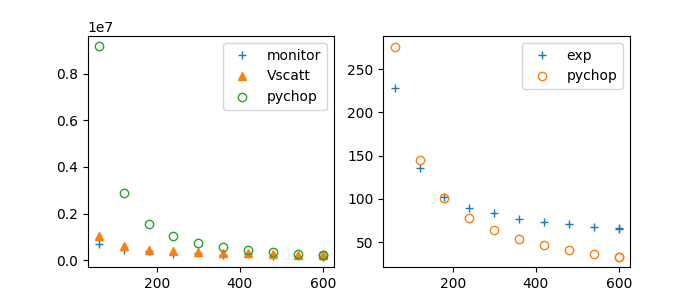

In [67]:
model_flux, model_res = flux_res_list_pychop(freqs, Ei=Ei).T

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
# plt.plot(mcvine_freqs[mcvine_conditions], mcvine_counts[mcvine_conditions], 'v', mfc='none', label='mcvine')
plt.plot(freqs, mint*C.e2v(Ei)*scale_monitor2mcvine, '+', label='monitor')
plt.plot(freqs, expdata.intensity[condition]*scale_vscatt2mcvine, '^', label='Vscatt')
plt.plot(freqs, model_flux*flux_scale, 'o', mfc='none', label='pychop')
plt.legend()

plt.subplot(1,2,2)
# plt.plot(mcvine_freqs[mcvine_conditions], mcvine_FWHMs[mcvine_conditions], 'v', mfc='none', label='mcvine')
plt.plot(freqs, expdata.FWHM[condition], '+', label='exp')
plt.plot(freqs, model_res, 'o', mfc='none', label='pychop')

plt.legend()

# Try plotting more Eis

In [34]:
def getExpXY(Ei):
    "return freq, monitor intensity, V scatt intensity, FWHM"
    condition = np.isclose(expdata.vdata.Energy, Ei)
    x = expdata.chopper_freqs[condition]
    y1 = np.array([runno2monitorint[rn] for rn in expdata.vdata.RunNumber[condition]]) *C.e2v(Ei) * scale_monitor2mcvine
    y2 = expdata.intensity[condition]*scale_vscatt2mcvine
    y3 = expdata.FWHM[condition]
    return x,y1,y2,y3

In [35]:
"""
def getMcvineXY(Ei):
    "return freq, counts, FWHM"
    mcvine_conditions = np.isclose(mcvine_Eis, Ei)
    freqs = mcvine_freqs[mcvine_conditions]
    counts = mcvine_counts[mcvine_conditions]
    FWHMs = mcvine_FWHMs[mcvine_conditions]
    return freqs, counts, FWHMs
"""

'\ndef getMcvineXY(Ei):\n    "return freq, counts, FWHM"\n    mcvine_conditions = np.isclose(mcvine_Eis, Ei)\n    freqs = mcvine_freqs[mcvine_conditions]\n    counts = mcvine_counts[mcvine_conditions]\n    FWHMs = mcvine_FWHMs[mcvine_conditions]\n    return freqs, counts, FWHMs\n'

<IPython.core.display.Javascript object>


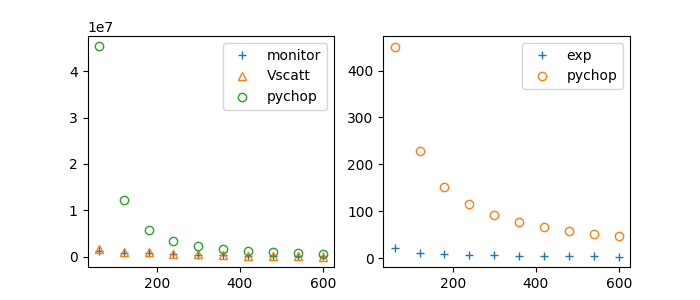

In [36]:
Ei = 100
freqs, monInt, vscattInt, expFWHM = getExpXY(Ei)
model_flux, model_res = flux_res_list_pychop(freqs).T
# mcv_freqs, mcv_Int, mcv_FWHM = getMcvineXY(Ei)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
# plt.plot(mcv_freqs, mcv_Int, 'v', mfc='none', label='mcvine')
plt.plot(freqs, monInt, '+', label='monitor')
plt.plot(freqs, vscattInt, '^', mfc='none', label='Vscatt')
plt.plot(freqs, model_flux*flux_scale, 'o', mfc='none', label='pychop')
plt.legend()

plt.subplot(1,2,2)
# plt.plot(mcv_freqs, mcv_FWHM, 'v', mfc='none', label='mcvine')
plt.plot(freqs, expFWHM, '+', label='exp')
plt.plot(freqs, model_res, 'o', mfc='none', label='pychop')

plt.legend()

In [37]:
set(expdata.vdata.Energy)

{8.0,
 10.0,
 12.0,
 15.0,
 20.0,
 25.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0,
 120.0,
 125.0,
 150.0,
 200.0,
 250.0,
 300.0,
 400.0,
 500.0,
 600.0,
 700.0,
 800.0,
 900.0,
 1000.0,
 1200.0,
 1500.0,
 1800.0,
 2000.0,
 2500.0,
 3000.0,
 3500.0,
 4000.0,
 5000.0,
 6000.0,
 8000.0,
 10000.0}

<IPython.core.display.Javascript object>


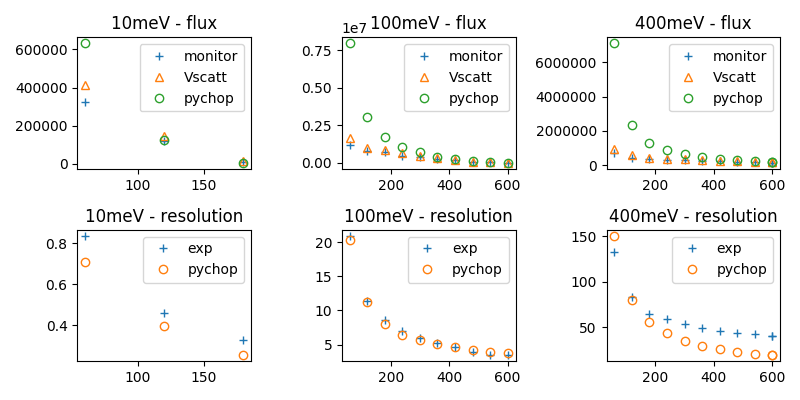

In [69]:
Eilist = [10, 100, 400]
N = len(Eilist)
plt.figure(figsize=(8,4))

for i, Ei in enumerate(Eilist):
    freqs, monInt, vscattInt, expFWHM = getExpXY(Ei)
    model_flux, model_res = flux_res_list_pychop(freqs,  Ei=Ei, fc_rho=1500).T
    # mcv_freqs, mcv_Int, mcv_FWHM = getMcvineXY(Ei)

    plt.subplot(2, N, i+1)
    plt.title('%smeV - flux' % Ei)
    # plt.plot(mcv_freqs, mcv_Int, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, monInt, '+', label='monitor')
    plt.plot(freqs, vscattInt, '^', mfc='none', label='Vscatt')
    plt.plot(freqs, model_flux*flux_scale, 'o', mfc='none', label='pychop')
    plt.legend()

    plt.subplot(2, N, N+i+1)
    plt.title('%smeV - resolution' % Ei)
    # plt.plot(mcv_freqs, mcv_FWHM, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, expFWHM, '+', label='exp')
    plt.plot(freqs, model_res, 'o', mfc='none', label='pychop')

    plt.legend()
plt.tight_layout()

# All energies

In [39]:
unique_nominal_Eis

{8.0,
 10.0,
 12.0,
 15.0,
 20.0,
 25.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0,
 120.0,
 125.0,
 150.0,
 200.0,
 250.0,
 300.0,
 400.0,
 500.0,
 600.0,
 700.0,
 800.0,
 900.0,
 1000.0,
 1200.0,
 1500.0,
 1800.0,
 2000.0,
 2500.0,
 3000.0,
 3500.0,
 4000.0,
 5000.0,
 6000.0,
 8000.0,
 10000.0}

In [81]:
Ei_list = sorted(unique_nominal_Eis)
datatable = dict()
import warnings
for Ei in Ei_list:
    freqs, monInt, vscattInt, expFWHM = getExpXY(Ei)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model_flux, model_res = flux_res_list_pychop(freqs, Ei=Ei, fc_pslit=1.).T
    # mcv_freqs, mcv_Int, mcv_FWHM = getMcvineXY(Ei)
    datatable[Ei] = freqs, monInt, vscattInt, expFWHM, model_flux, model_res# , mcv_freqs, mcv_Int, mcv_FWHM

<IPython.core.display.Javascript object>


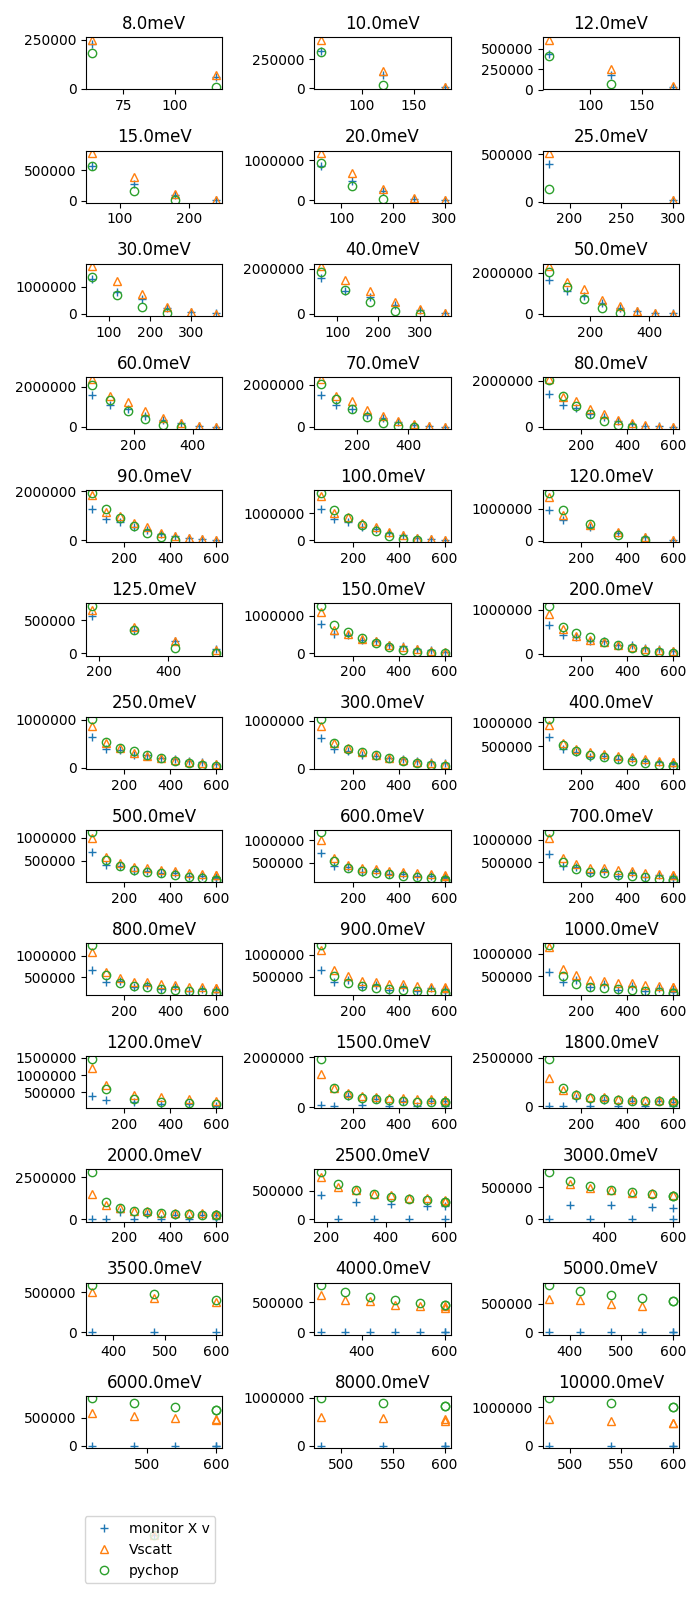

In [82]:
N = len(Ei_list)
cols = 3
# rows = (N-1)//cols + 1
rows = N//cols + 1
plt.figure(figsize=(7,16))

for i, Ei in enumerate(Ei_list):
    # freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res = datatable[Ei]
    plt.subplot(rows, cols, i+1)
    plt.title('%smeV' % Ei)
    # plt.plot(mcv_freqs, mcv_Int, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, monInt, '+', label='monitor')
    plt.plot(freqs, vscattInt, '^', mfc='none', label='Vscatt')
    plt.plot(freqs, model_flux*flux_scale, 'o', mfc='none', label='pychop')
plt.subplot(rows, cols, N+1)
plt.axis('off')
# plt.plot([0], [0], '^', label='mcvine')
plt.plot([0], [0], '+', label='monitor X v')
plt.plot([0], [0], '^', mfc='none', label='Vscatt')
plt.plot([0], [0], 'o', mfc='none', label='pychop')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


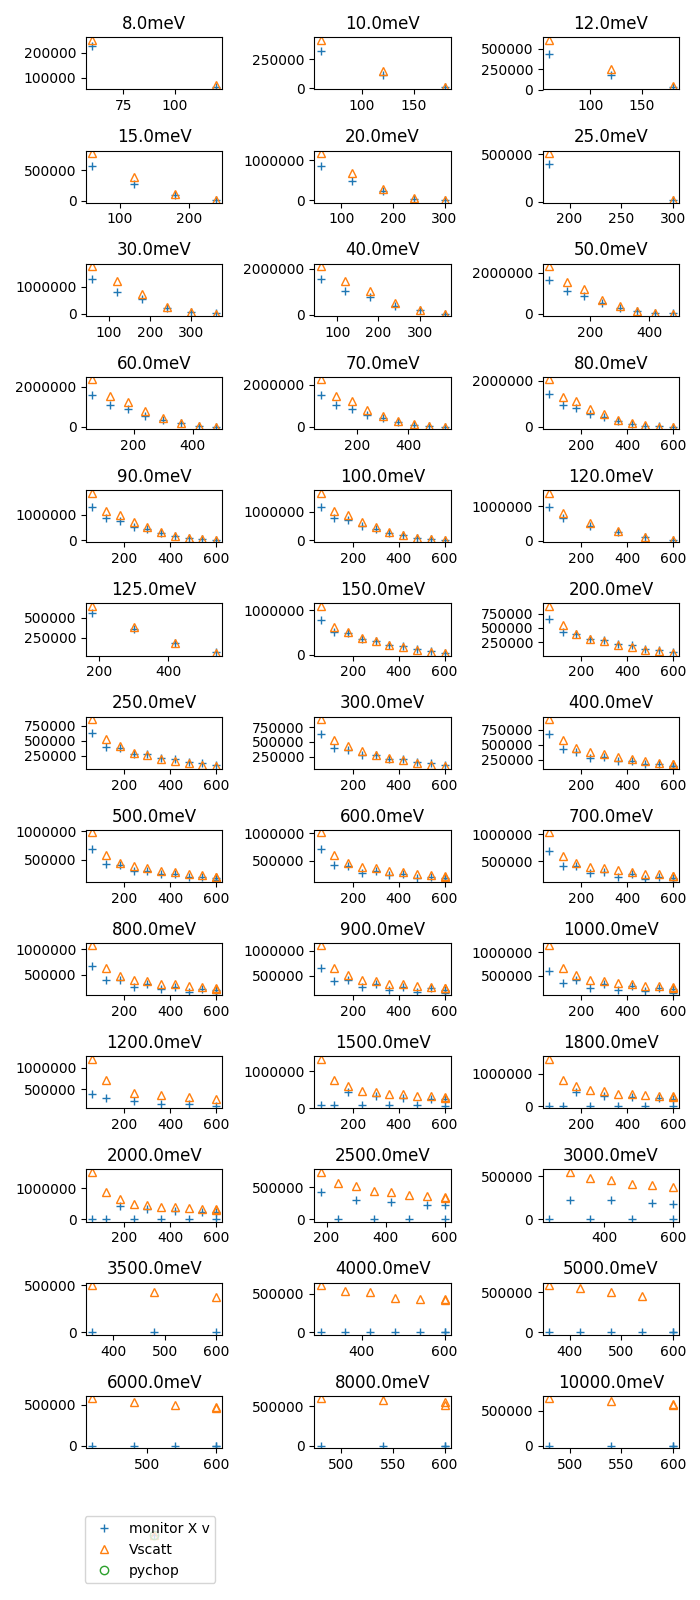

In [53]:
N = len(Ei_list)
cols = 3
# rows = (N-1)//cols + 1
rows = N//cols + 1
plt.figure(figsize=(7,16))

for i, Ei in enumerate(Ei_list):
    # freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res = datatable[Ei]
    plt.subplot(rows, cols, i+1)
    plt.title('%smeV' % Ei)
    # plt.plot(mcv_freqs, mcv_Int, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, monInt, '+', label='monitor')
    plt.plot(freqs, vscattInt, '^', mfc='none', label='Vscatt')
    # plt.plot(freqs, model_flux*flux_scale, 'o', mfc='none', label='pychop')
plt.subplot(rows, cols, N+1)
plt.axis('off')
# plt.plot([0], [0], '^', label='mcvine')
plt.plot([0], [0], '+', label='monitor X v')
plt.plot([0], [0], '^', mfc='none', label='Vscatt')
plt.plot([0], [0], 'o', mfc='none', label='pychop')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


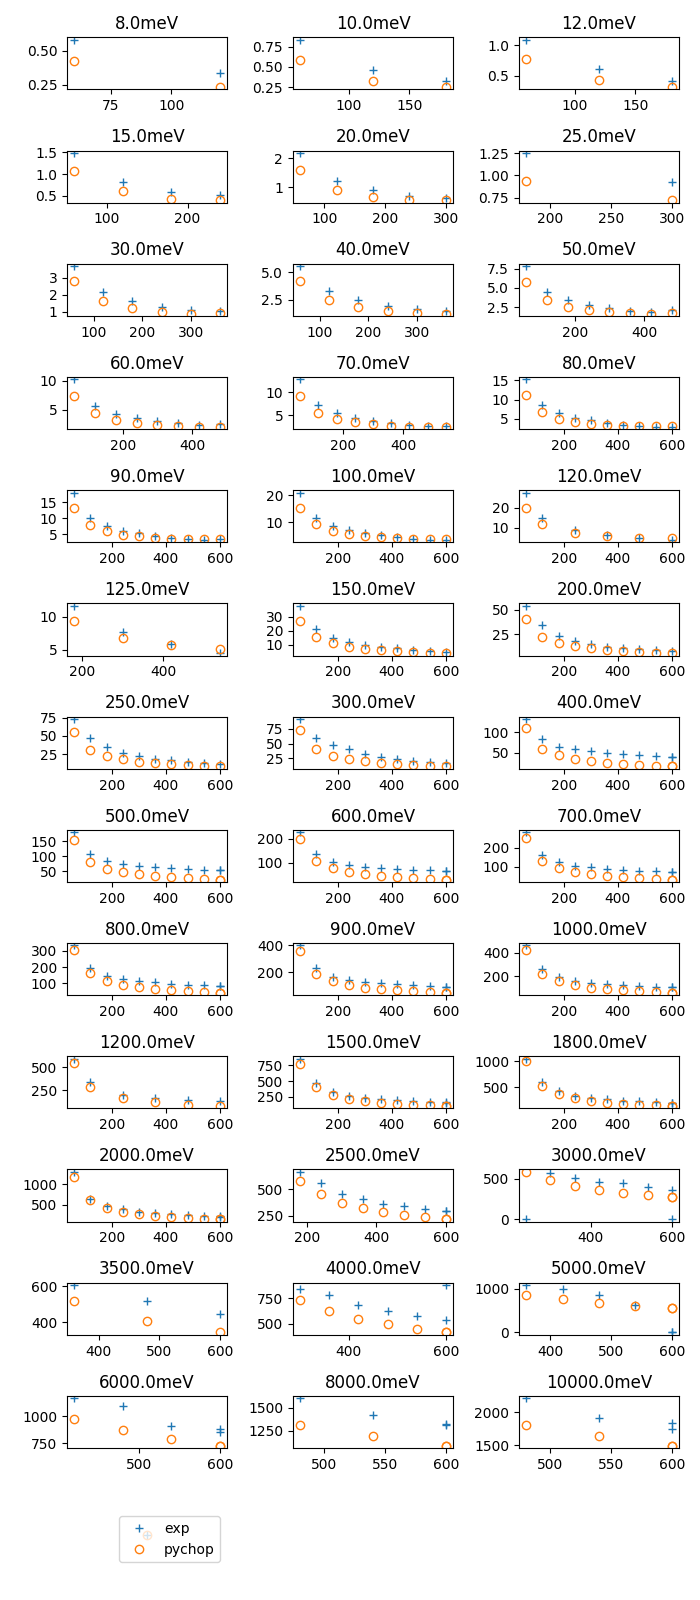

In [83]:
N = len(Ei_list)
cols = 3
# rows = (N-1)//cols + 1
rows = N//cols + 1
plt.figure(figsize=(7,16))

for i, Ei in enumerate(Ei_list):
    # freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res = datatable[Ei]
    plt.subplot(rows, cols, i+1)
    plt.title('%smeV' % Ei)
    # plt.plot(mcv_freqs, mcv_FWHM, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, expFWHM, '+', label='exp')
    plt.plot(freqs, model_res, 'o', mfc='none', label='pychop')
plt.subplot(rows, cols, N+1)
plt.axis('off')
# plt.plot([0], [0], 'v', mfc='none', label='mcvine')
plt.plot([0], [0], '+', label='exp')
plt.plot([0], [0], 'o', mfc='none', label='pychop')
plt.legend()
plt.tight_layout()

# Some conclusions

* intensity does not agree well
* resolution agrees mostly
* T0 chopper influence?

# Save data

In [84]:
rows = []
for Ei in datatable.keys():
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res = datatable[Ei]
    rows += list(zip(freqs, monInt, vscattInt))

dict